<h1><center> COSC 4337 Data Science II Second Milestone</center></h1>

## Data Loading & Pre-processing

In [1]:
import pandas as pd

data = pd.read_csv('SoilOrganicCarbonRecovery_NorthwestTerritories.csv')
print(data.head())

print("Null values found in columns:")
data.isnull().sum()

# 2. Drop rows with missing data
data.dropna(inplace=True)
data.isnull().sum()

     plot burn   site        date  decid_prop_canopy  piba_prop_canopy  \
0  C1-14A   C1  C1-14  2018-06-13           0.032258          0.709677   
1  C1-17A   C1  C1-17  2018-06-10           0.000000          0.000000   
2  C1-19A   C1  C1-19  2018-06-13           0.000000          0.000000   
3  C1-19B   C1  C1-19  2018-06-13           0.000000          0.650000   
4  C1-21A   C1  C1-21  2018-06-14           0.023529          0.000000   

  stand_dominance  time_after_fire moisture nonvascular_functionalgroup  \
0       Jack Pine               83    Xeric                      Lichen   
1    Black Spruce               65    Mesic                      Lichen   
2    Black Spruce               82   Hydric                    Sphagnum   
3       Jack Pine               84    Xeric                      Lichen   
4    Black Spruce               79   Hydric                  Colonizers   

   avg_org_carbon ecozone  avg_carbon_stock   latitude  longitude   
0            4.05  shield          

plot                           0
burn                           0
site                           0
date                           0
decid_prop_canopy              0
piba_prop_canopy               0
stand_dominance                0
time_after_fire                0
moisture                       0
nonvascular_functionalgroup    0
avg_org_carbon                 0
ecozone                        0
avg_carbon_stock               0
latitude                       0
longitude                      0
dtype: int64

### Linear Model - Radhika Sonde

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [7]:
# correlation matrix
column_indices = [4, 5, 7, 10, 12]
subset_data = data.iloc[:, column_indices]
correlation_matrix = subset_data.corr()

# Formatting
correlation_df = pd.DataFrame(correlation_matrix)
correlation_df = correlation_df.round(4)

# Print the correlation matrix with nicer formatting
print("Correlation Matrix:")
print(correlation_df.to_string())

Correlation Matrix:
                   decid_prop_canopy  piba_prop_canopy  time_after_fire  avg_org_carbon  avg_carbon_stock
decid_prop_canopy             1.0000           -0.0695           0.0394         -0.2634           -0.2826
piba_prop_canopy             -0.0695            1.0000           0.1470         -0.3906           -0.3781
time_after_fire               0.0394            0.1470           1.0000          0.1162            0.0335
avg_org_carbon               -0.2634           -0.3906           0.1162          1.0000            0.8105
avg_carbon_stock             -0.2826           -0.3781           0.0335          0.8105            1.0000


From the correlation matrix, we can see that the strongest relationship is between avg_org_carbon and avg_carbon_stock

In [7]:
# Building linear model
model = sm.OLS(data['avg_org_carbon'], sm.add_constant(data[['avg_carbon_stock', 'decid_prop_canopy', 'piba_prop_canopy', 'time_after_fire']])).fit()

# Print summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         avg_org_carbon   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     195.5
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           1.39e-89
Time:                        17:04:44   Log-Likelihood:                -1331.8
No. Observations:                 372   AIC:                             2674.
Df Residuals:                     367   BIC:                             2693.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.5300      1.05

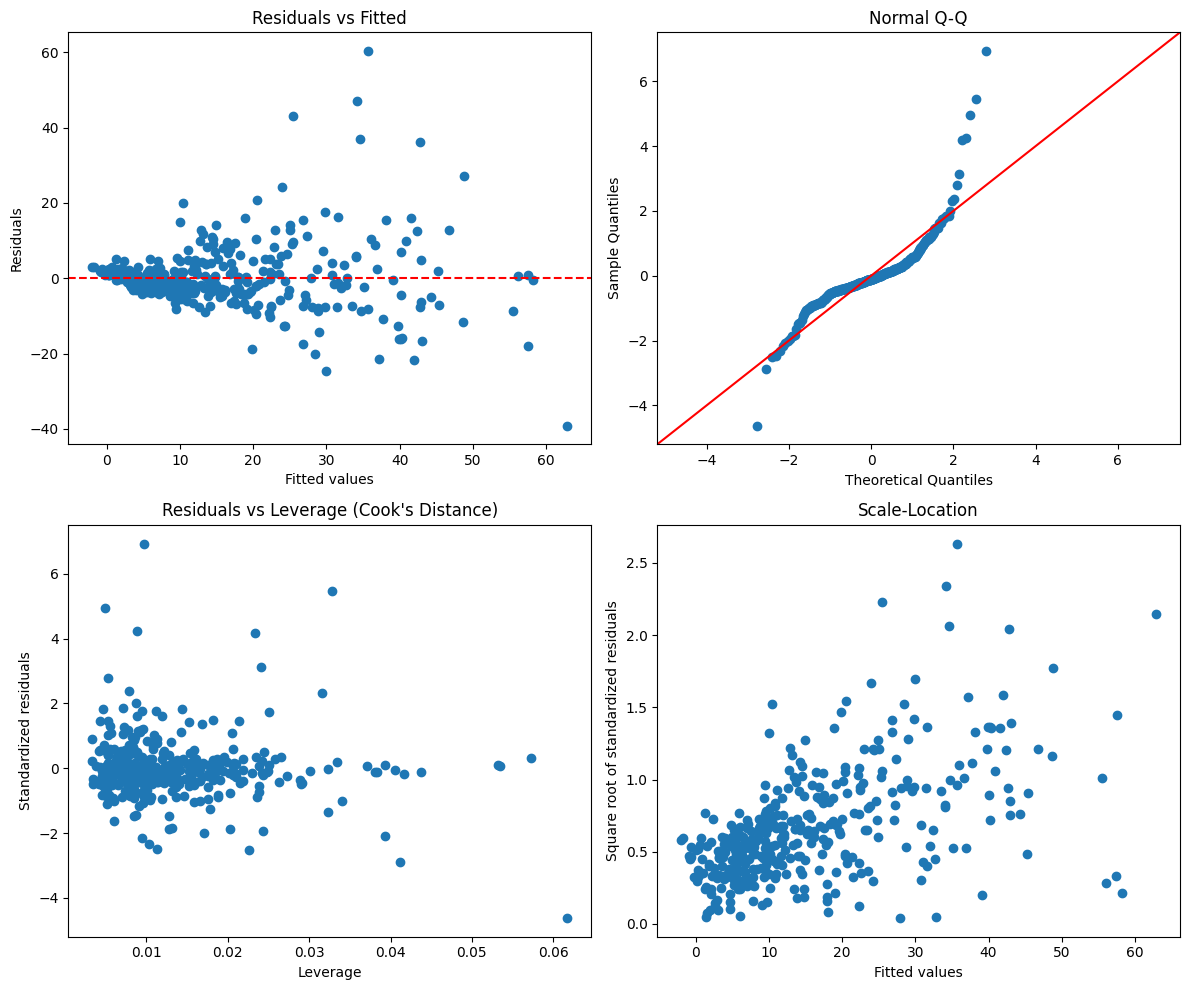

In [16]:
# Compute Cook's distance
influence = model.get_influence()

# Diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Residual vs Fitted
residuals = model.resid
fitted = model.fittedvalues
axes[0, 0].scatter(fitted, residuals)
axes[0, 0].set_xlabel('Fitted values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted')
axes[0, 0].axhline(y=0, color='r', linestyle='--')

# Normal Q-Q plot
residuals_standardized = influence.resid_studentized_internal
sm.qqplot(residuals_standardized, line='45', ax=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q')

# Residuals vs Leverage plot with Cook's distance
axes[1, 0].scatter(influence.hat_matrix_diag, residuals_standardized)
axes[1, 0].set_xlabel('Leverage')
axes[1, 0].set_ylabel("Standardized residuals")
axes[1, 0].set_title("Residuals vs Leverage (Cook's Distance)")

# Scale-location plot
sqrt_abs_standardized_resid = np.sqrt(np.abs(residuals_standardized))
axes[1, 1].scatter(fitted, sqrt_abs_standardized_resid)
axes[1, 1].set_xlabel('Fitted values')
axes[1, 1].set_ylabel('Square root of standardized residuals')
axes[1, 1].set_title('Scale-Location')

plt.tight_layout()
plt.show()


Rough Step Function

In [24]:
X = data[['avg_carbon_stock', 'decid_prop_canopy', 'piba_prop_canopy', 'time_after_fire']]
y = data['avg_org_carbon']

def forward_selection(X, y):
    features = X.columns
    best_features = []
    best_aic = float("inf")

    for feature in features:
        model = sm.OLS(y, sm.add_constant(X[best_features + [feature]])).fit()
        aic = model.aic
        if aic < best_aic:
            best_aic = aic
            best_features.append(feature)

    return best_features, best_aic

selected_features, best_aic = forward_selection(X, y)
print("Selected features:", selected_features)
print("Best AIC:", best_aic)

Selected features: ['avg_carbon_stock', 'piba_prop_canopy', 'time_after_fire']
Best AIC: 2676.3645294471535


Removing outliers

In [19]:
# Removing rows with indices 234, 266, and 271
data2 = data.drop([234, 266, 271])

# Building linear model without the outliers
model2 = sm.OLS(data2['avg_org_carbon'], sm.add_constant(data2[['avg_carbon_stock', 'decid_prop_canopy', 'piba_prop_canopy', 'time_after_fire']])).fit()

# Summary of linear regression model
print("\nSummary of Linear Regression Model (Excluding Rows 234, 266, and 271):")
print(model2.summary())


Summary of Linear Regression Model (Excluding Rows 234, 266, and 271):
                            OLS Regression Results                            
Dep. Variable:         avg_org_carbon   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     192.9
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           1.47e-88
Time:                        17:26:10   Log-Likelihood:                -1322.4
No. Observations:                 369   AIC:                             2655.
Df Residuals:                     364   BIC:                             2674.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

Transforming to Normalize Data

In [20]:
transformed_data = data.copy()  # Copy the original DataFrame
numeric_vars = transformed_data[['avg_carbon_stock', 'decid_prop_canopy', 'piba_prop_canopy', 'time_after_fire', 'avg_org_carbon']]

# Logarithmic transformation
log_transformed_data = numeric_vars.apply(np.log1p)
# Update the transformed data back to the original DataFrame
transformed_data[['avg_carbon_stock', 'decid_prop_canopy', 'piba_prop_canopy', 'time_after_fire', 'avg_org_carbon']] = log_transformed_data


In [21]:
# Building linear model with transformed data
model3 = sm.OLS(transformed_data['avg_org_carbon'], sm.add_constant(transformed_data[['avg_carbon_stock', 'decid_prop_canopy', 'piba_prop_canopy', 'time_after_fire']])).fit()

# Summary of linear regression model
print("\nSummary of Linear Regression Model with Transformed Data:")
print(model3.summary())


Summary of Linear Regression Model with Transformed Data:
                            OLS Regression Results                            
Dep. Variable:         avg_org_carbon   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     419.1
Date:                Wed, 10 Apr 2024   Prob (F-statistic):          2.21e-135
Time:                        17:31:09   Log-Likelihood:                -175.29
No. Observations:                 372   AIC:                             360.6
Df Residuals:                     367   BIC:                             380.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

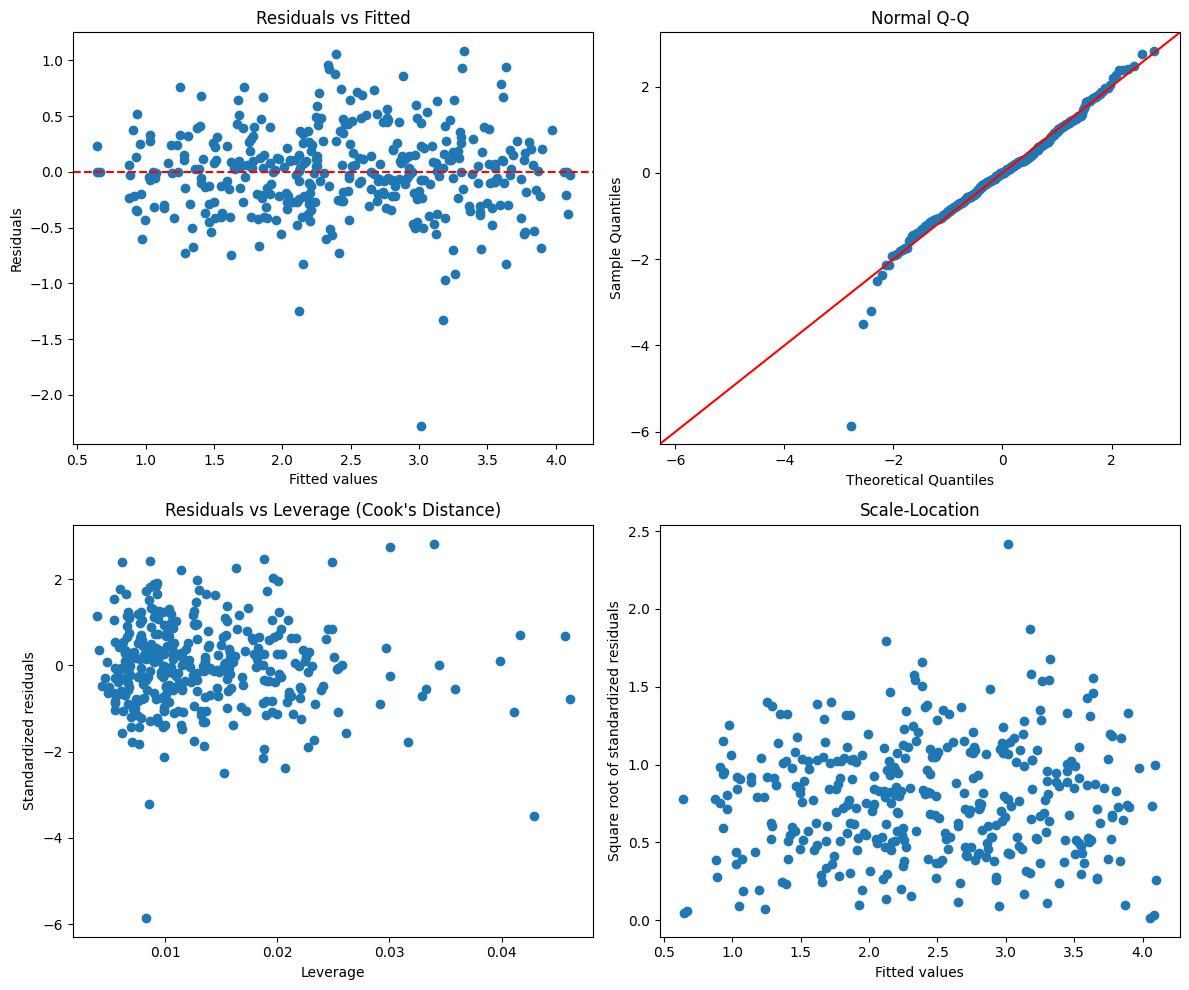

In [22]:
# Compute Cook's distance
influence = model3.get_influence()

# Diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Residual vs Fitted
residuals = model3.resid
fitted = model3.fittedvalues
axes[0, 0].scatter(fitted, residuals)
axes[0, 0].set_xlabel('Fitted values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted')
axes[0, 0].axhline(y=0, color='r', linestyle='--')

# Normal Q-Q plot
residuals_standardized = influence.resid_studentized_internal
sm.qqplot(residuals_standardized, line='45', ax=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q')

# Residuals vs Leverage plot with Cook's distance
axes[1, 0].scatter(influence.hat_matrix_diag, residuals_standardized)
axes[1, 0].set_xlabel('Leverage')
axes[1, 0].set_ylabel("Standardized residuals")
axes[1, 0].set_title("Residuals vs Leverage (Cook's Distance)")

# Scale-location plot
sqrt_abs_standardized_resid = np.sqrt(np.abs(residuals_standardized))
axes[1, 1].scatter(fitted, sqrt_abs_standardized_resid)
axes[1, 1].set_xlabel('Fitted values')
axes[1, 1].set_ylabel('Square root of standardized residuals')
axes[1, 1].set_title('Scale-Location')

plt.tight_layout()
plt.show()


In [9]:
X = data['avg_org_carbon'].values.reshape(-1, 1)  # Reshape the input feature
y = data['avg_carbon_stock'].values

# Create and fit the model
model = LinearRegression().fit(X, y)

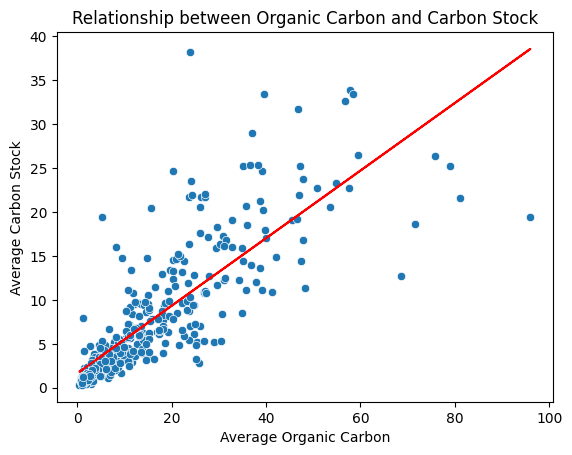

In [15]:
sns.scatterplot(x=X.flatten(), y=y)
plt.xlabel('Average Organic Carbon')
plt.ylabel('Average Carbon Stock')
plt.title('Relationship between Organic Carbon and Carbon Stock')
plt.plot(X.flatten(), model.predict(X), color='red')
plt.show()

In [20]:
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R-squared:", model.score(X, y))
print("R:", np.sqrt(model.score(X, y)))

Coefficients: [0.38420564]
Intercept: 1.6463168562548969
R-squared: 0.656858792733177
R: 0.8104682552285296


### Clustering \ DBSCAN - Roberto Jackson Baeza

In [29]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
import random

In [33]:
csvdata = pd.read_csv('SoilOrganicCarbonRecovery_NorthwestTerritories.csv')
print(csvdata.head())

     plot burn   site        date  decid_prop_canopy  piba_prop_canopy  \
0  C1-14A   C1  C1-14  2018-06-13           0.032258          0.709677   
1  C1-17A   C1  C1-17  2018-06-10           0.000000          0.000000   
2  C1-19A   C1  C1-19  2018-06-13           0.000000          0.000000   
3  C1-19B   C1  C1-19  2018-06-13           0.000000          0.650000   
4  C1-21A   C1  C1-21  2018-06-14           0.023529          0.000000   

  stand_dominance  time_after_fire moisture nonvascular_functionalgroup  \
0       Jack Pine               83    Xeric                      Lichen   
1    Black Spruce               65    Mesic                      Lichen   
2    Black Spruce               82   Hydric                    Sphagnum   
3       Jack Pine               84    Xeric                      Lichen   
4    Black Spruce               79   Hydric                  Colonizers   

   avg_org_carbon ecozone  avg_carbon_stock   latitude  longitude   
0            4.05  shield          

In [34]:
csvdata.isnull().sum()
csvdata.dropna(inplace=True)
csvdata.reset_index(drop=True, inplace=True)

desiredColumns = ["decid_prop_canopy", "piba_prop_canopy", "time_after_fire", "moisture", "avg_org_carbon", "ecozone", "avg_carbon_stock"]
data = csvdata[desiredColumns]
#print(data.head())
data

,decid_prop_canopy,piba_prop_canopy,time_after_fire,moisture,avg_org_carbon,ecozone,avg_carbon_stock
0,0.032258,0.709677,83,Xeric,4.05,shield,2.557465
1,0.000000,0.000000,65,Mesic,10.70,shield,3.798638
2,0.000000,0.000000,82,Hydric,25.75,shield,2.870864
3,0.000000,0.650000,84,Xeric,5.10,shield,2.092274
4,0.023529,0.000000,79,Hydric,27.95,shield,12.764497
...,...,...,...,...,...,...,...
367,0.920000,0.080000,1,Xeric,1.30,plains,1.390676
368,0.375000,0.500000,1,Xeric,2.70,plains,1.300133
369,0.000000,0.070423,1,Mesic,5.85,plains,3.073747
370,0.000000,0.000000,1,Hydric,20.60,plains,11.539966


In [35]:
ecoMap = {"shield":0 , "plains": 1}
moistMap = {"Xeric":0, "Mesic":0.5, "Hydric":1}
mmNormalizedCols = ["decid_prop_canopy", "piba_prop_canopy", "time_after_fire", "avg_org_carbon", "avg_carbon_stock"]


for col in mmNormalizedCols:
  maxVal = data[col].max()
  minVal = data[col].min()
  data[col] = (data[col] - minVal) / (maxVal - minVal)

data.loc[data["ecozone"] == "shield", "ecozone"] = 0.0
data.loc[data["ecozone"] == "plains", "ecozone"] = 1.0


data.loc[data["moisture"] == "Xeric", "moisture"] = 0.0
data.loc[data["moisture"] == "Mesic", "moisture"] = 0.5
data.loc[data["moisture"] == "Hydric", "moisture"] = 1.0

print(data)

     decid_prop_canopy  piba_prop_canopy  time_after_fire moisture  \
0             0.032625          0.709677         0.828283      0.0   
1             0.000000          0.000000         0.646465      0.5   
2             0.000000          0.000000         0.818182      1.0   
3             0.000000          0.650000         0.838384      0.0   
4             0.023797          0.000000         0.787879      1.0   
..                 ...               ...              ...      ...   
367           0.930455          0.080000         0.000000      0.0   
368           0.379261          0.500000         0.000000      0.0   
369           0.000000          0.070423         0.000000      0.5   
370           0.000000          0.000000         0.000000      1.0   
371           0.233392          0.769231         0.000000      0.0   

     avg_org_carbon ecozone  avg_carbon_stock  
0          0.037677     0.0          0.059010  
1          0.107274     0.0          0.091811  
2          0.26

C:\Users\baeza\AppData\Local\Temp\ipykernel_30628\1211403850.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = (data[col] - minVal) / (maxVal - minVal)
C:\Users\baeza\AppData\Local\Temp\ipykernel_30628\1211403850.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = (data[col] - minVal) / (maxVal - minVal)


In [36]:
basicModel = DBSCAN(eps=0.5, min_samples=5)

basicModel.fit(data[desiredColumns])

clusterLabels = basicModel.labels_
dataClusters = pd.concat([data, pd.Series(clusterLabels, name='Cluster')], axis=1)

print(dataClusters.head())
print("\nSilhouette Score for Basic Model: " + str(metrics.silhouette_score(dataClusters, dataClusters['Cluster'])))


   decid_prop_canopy  piba_prop_canopy  time_after_fire moisture  \
0           0.032625          0.709677         0.828283      0.0   
1           0.000000          0.000000         0.646465      0.5   
2           0.000000          0.000000         0.818182      1.0   
3           0.000000          0.650000         0.838384      0.0   
4           0.023797          0.000000         0.787879      1.0   

   avg_org_carbon ecozone  avg_carbon_stock  Cluster  
0        0.037677     0.0          0.059010        0  
1        0.107274     0.0          0.091811        1  
2        0.264783     0.0          0.067292        2  
3        0.048666     0.0          0.046717        0  
4        0.287807     0.0          0.328750        2  

Silhouette Score for Basic Model: 0.5500387623625556


In [80]:
desiredColumns = ["decid_prop_canopy", "piba_prop_canopy", "time_after_fire", "moisture", "avg_org_carbon", "ecozone", "avg_carbon_stock"]
randomEpsilons = [random.random() for _ in range(20)]
randomMinPoints = [random.randint(3,25) for _ in range(20)]

bestR1Epsilon = 0
bestR1MinPoints = 0
BestR1SilhoutteScore = -1

for i in range(20):
    modelR1 = DBSCAN(eps=randomEpsilons[i], min_samples=randomMinPoints[i])
    modelR1.fit(data[desiredColumns])

    modelR1ClusterLabels = modelR1.labels_
    modelR1Clusters = pd.concat([data, pd.Series(modelR1ClusterLabels, name='Cluster')], axis=1)
    modelR1ClusterCount = len(set(modelR1ClusterLabels))

    if(modelR1ClusterCount > 2):
        model1Score = metrics.silhouette_score(modelR1Clusters, modelR1Clusters['Cluster'])
    else:
        model1Score = -1

    if(model1Score > BestR1SilhoutteScore):
        BestR1SilhoutteScore = model1Score
        bestR1Epsilon = randomEpsilons[i]
        bestR1MinPoints = randomMinPoints[i]


print("Best Round 1 Score: " +  str(BestR1SilhoutteScore))
print("Best Round 2 Epsilon: " + str(bestR1Epsilon))
print("Best Round 2 MinPoint: " + str(bestR1MinPoints))

Best Score: 0.6462038637177934
Best Epsilon: 0.3022386542724167
Best MinPoint: 9


In [81]:
desiredColumns = ["decid_prop_canopy", "piba_prop_canopy", "time_after_fire", "moisture", "avg_org_carbon", "ecozone", "avg_carbon_stock"]
randomEpsilons = [random.uniform(bestR1Epsilon * 0.5, bestR1Epsilon * 1.5) for _ in range(20)]
randomMinPoints = [random.randint(int(bestR1MinPoints*.5),int(bestR1MinPoints*1.5)) for _ in range(20)]

bestR2Epsilon = bestR1Epsilon
bestR2MinPoints = bestR1MinPoints
BestR2SilhoutteScore = BestR1SilhoutteScore

for i in range(20):
    modelR2 = DBSCAN(eps=randomEpsilons[i], min_samples=randomMinPoints[i])
    modelR2.fit(data[desiredColumns])

    modelR2ClusterLabels = modelR2.labels_
    modelR2Clusters = pd.concat([data, pd.Series(modelR2ClusterLabels, name='Cluster')], axis=1)
    modelR2ClusterCount = len(set(modelR2ClusterLabels))


    if(modelR2ClusterCount > 2):
        modelR2Score = metrics.silhouette_score(modelR2Clusters, modelR2Clusters['Cluster'])
    else:
        modelR2Score = -1

    if(modelR2Score > BestR2SilhoutteScore):
        BestR2SilhoutteScore = modelR2Score
        bestR2Epsilon = randomEpsilons[i]
        bestR2MinPoints = randomMinPoints[i]


print("Best Round 2 Score: " +  str(BestR2SilhoutteScore))
print("Best Round 2 Epsilon: " + str(bestR2Epsilon))
print("Best Round 2 MinPoint: " + str(bestR2MinPoints))

Best Round 2 Score: 0.6708834418343176
Best Round 2 Epsilon: 0.25552877375526106
Best Round 2 MinPoint: 7


In [84]:
desiredColumns = ["decid_prop_canopy", "piba_prop_canopy", "time_after_fire", "moisture", "avg_org_carbon", "ecozone", "avg_carbon_stock"]
randomEpsilons = [random.uniform(bestR2Epsilon * 0.75, bestR2Epsilon * 1.2) for _ in range(20)]
randomMinPoints = [random.randint(int(bestR2MinPoints*.75),int(bestR2MinPoints*1.25)) for _ in range(20)]

bestR3Epsilon = bestR2Epsilon
bestR3MinPoints = bestR2MinPoints
BestR3SilhoutteScore = BestR2SilhoutteScore

for i in range(20):
    modelR3 = DBSCAN(eps=randomEpsilons[i], min_samples=randomMinPoints[i])
    modelR3.fit(data[desiredColumns])

    modelR3ClusterLabels = modelR3.labels_
    modelR3Clusters = pd.concat([data, pd.Series(modelR3ClusterLabels, name='Cluster')], axis=1)
    modelR3ClusterCount = len(set(modelR3ClusterLabels))


    if(modelR3ClusterCount > 2):
        modelR3Score = metrics.silhouette_score(modelR3Clusters, modelR3Clusters['Cluster'])
    else:
        modelR3Score = -1

    if(modelR3Score > BestR3SilhoutteScore):
        BestR3SilhoutteScore = modelR3Score
        bestR3Epsilon = randomEpsilons[i]
        bestR3MinPoints = randomMinPoints[i]


print("Best Round 3 Score: " +  str(BestR3SilhoutteScore))
print("Best Round 3 Epsilon: " + str(bestR3Epsilon))
print("Best Round 3 MinPoint: " + str(bestR3MinPoints))

Best Round 3 Score: 0.6829038115260956
Best Round 3 Epsilon: 0.2385849607088677
Best Round 3 MinPoint: 5


In [19]:
def plotData3D(dataset, x, y, z):
  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')

  ax.scatter(dataset[x], dataset[y], dataset[z], c=dataset['Cluster'], cmap='viridis')

  ax.set_xlabel(x)
  ax.set_ylabel(y)
  ax.set_zlabel(z)
  ax.set_title(x + " vs " + y + " vs " + z)

  plt.show()

### DO NOT RUN UNLESS YOU WANT A MILLION GRAPHS

In [ ]:
desiredColumns = ["decid_prop_canopy", "piba_prop_canopy", "time_after_fire", "moisture", "avg_org_carbon", "ecozone", "avg_carbon_stock"]
combinations_3_elements = list(combinations(desiredColumns, 3))

for combo in combinations_3_elements:
  plotData3D(dataClusters, combo[0], combo[1], combo[2])